In [1]:
import os
import json
import numpy as np
from scipy import interpolate

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#### Just the regular seaborn and matplotlib parameter tuning

In [2]:
# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.1',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

## Loading train data

In [3]:
tr_data_path = 'D:\\MS COCO\\train2014\\'

Collect image names

In [4]:
tr_prefix = 'COCO_train2014_'
tr_suffix = '.jpg'
# Image ID
# Always 12 numbers, starting with zeros
tr_index = []
for name in os.listdir(tr_data_path):
    tr_index.append(int(name.split('_')[-1].split('.')[0]))

Load an example image

In [5]:
def make_image_id(index):
    
    zeros = (12 - len(str(index))) * '0'
    return zeros + str(index)

In [6]:
# Get random filename
tr_rand_index = make_image_id(np.random.choice(tr_index))
tr_expample = tr_data_path + tr_prefix + tr_rand_index + tr_suffix
# Load image
tr_example_img = plt.imread(tr_expample)

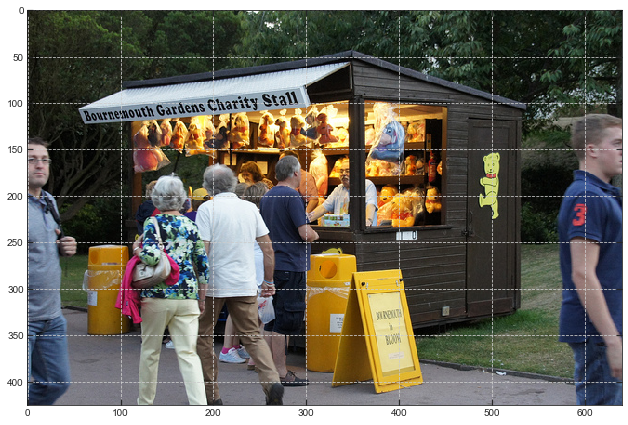

In [7]:
tr_fig_norm = 40
fig, axes = plt.subplots(figsize=tuple(t/tr_fig_norm for t in tr_example_img.shape[:2]))

axes.imshow(tr_example_img)

plt.show()

## Load numerous samples

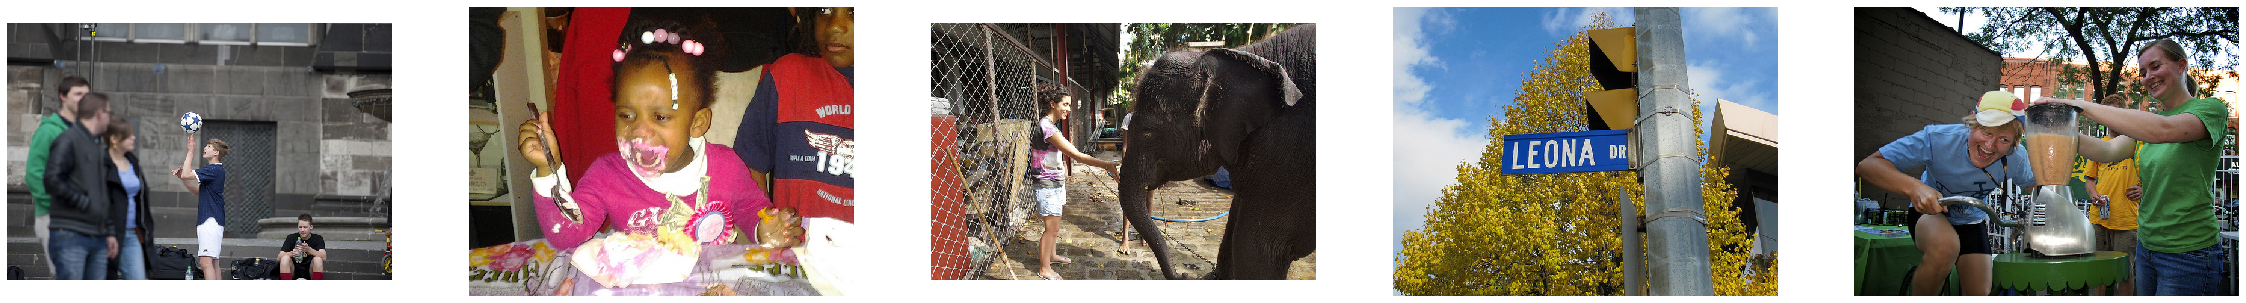

In [20]:
n_samples = 5
tr_fig_norm = 40
fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(n_samples*8, 1*8))

for i in range(n_samples):
    # Get random filename
    tr_rand_index = make_image_id(np.random.choice(tr_index))
    tr_expample = tr_data_path + tr_prefix + tr_rand_index + tr_suffix
    # Load image
    tr_example_img = plt.imread(tr_expample)

    axes[i].imshow(tr_example_img)
    axes[i].axis('off')

plt.savefig('./documentation/tex/img/sample_images.png',
            bbox_inches='tight')
plt.show()

## Loading train labels

In [21]:
label_path = 'D:\\MS COCO\\annotations\\'

In [22]:
tr_caps_json = 'captions_train2014.json'
with open(label_path + tr_caps_json, 'r') as f:
    tr_caps = json.load(f)

In [23]:
tr_labels_json = 'instances_train2014.json'
with open(label_path + tr_labels_json, 'r') as f:
    tr_labels = json.load(f)

In [24]:
tr_caption_keys = list(tr_caps.keys())
tr_annot_keys = list(tr_labels.keys())

In [25]:
print('Captions:', tr_caption_keys)
print('Labels:', tr_annot_keys)

Captions: ['info', 'images', 'licenses', 'annotations']
Labels: ['info', 'images', 'licenses', 'annotations', 'categories']


In [26]:
tr_caps['annotations'][0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

In [27]:
#tr_labels['annotations'][0]

### Collect supercategories

In [28]:
tr_labels['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [29]:
super_cats = list(set([entry['supercategory'] for entry in tr_labels['categories']]))
sub_ids = {entry['id']: idx for idx, entry in enumerate(tr_labels['categories'])}

In [30]:
super_cats

['outdoor',
 'sports',
 'appliance',
 'accessory',
 'food',
 'kitchen',
 'electronic',
 'furniture',
 'animal',
 'vehicle',
 'person',
 'indoor']

In [31]:
def set_super_cat_colors(super_cats, cmap, vmin=0, vmax=1):
    
    assert vmin >= 0, "Parameter \'vmin\' should be >=0 !"
    assert vmax <= 1, "Parameter \'vmax\' should be <=1 !"
    
    cmap_values = np.linspace(vmin, vmax, len(super_cats))
    colors = {cat: cmap(value) for cat, value in zip(super_cats, cmap_values)}
    
    return colors

In [32]:
super_cat_colors = set_super_cat_colors(super_cats=super_cats, cmap=cm.jet, vmin=0, vmax=1)

## Sorting annotation entries by image IDs

In [33]:
tr_sorted_caps = sorted(tr_caps['annotations'], key=lambda x: x['image_id'], reverse=False)
tr_sorted_annot = sorted(tr_labels['annotations'], key=lambda x: x['image_id'], reverse=False)

tr_index_in_caps = [entry['image_id'] for entry in tr_sorted_caps]
tr_index_in_annot = [entry['image_id'] for entry in tr_sorted_annot]

## Load a random train image with annotations

Choose a random image ID

In [41]:
tr_rand_index = np.random.choice(tr_index)
print('Random image ID: {0}'.format(tr_rand_index))

Random image ID: 141654


In [42]:
tr_expample = tr_data_path + tr_prefix + make_image_id(tr_rand_index) + tr_suffix
# Load image
tr_example_img = plt.imread(tr_expample)

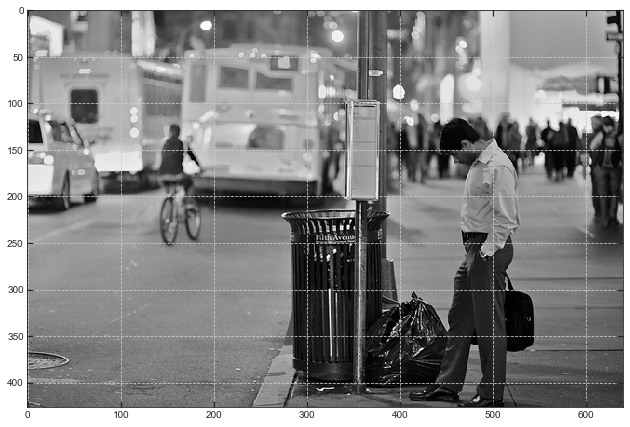

In [43]:
tr_fig_norm = 40
fig, axes = plt.subplots(figsize=tuple(t/tr_fig_norm for t in tr_example_img.shape[:2]))

axes.imshow(tr_example_img)

plt.show()

Collect all entries from `tr_caps['annotations']` and `tr_labels['annotations']`, which is linked to the randomly chosen image

In [44]:
tr_rand_caps_locs = np.where(tr_index_in_caps == tr_rand_index)[0]
tr_rand_annot_locs = np.where(tr_index_in_annot == tr_rand_index)[0]

In [45]:
print(tr_rand_caps_locs)
print(tr_rand_annot_locs)

[101302 101303 101304 101305 101306]
[148255 148256 148257 148258 148259 148260 148261 148262 148263 148264
 148265 148266 148267 148268 148269 148270 148271 148272 148273 148274]


In [46]:
tf_rand_caps = [tr_sorted_caps[idx] for idx in tr_rand_caps_locs]
tf_rand_annot = [tr_sorted_annot[idx] for idx in tr_rand_annot_locs]

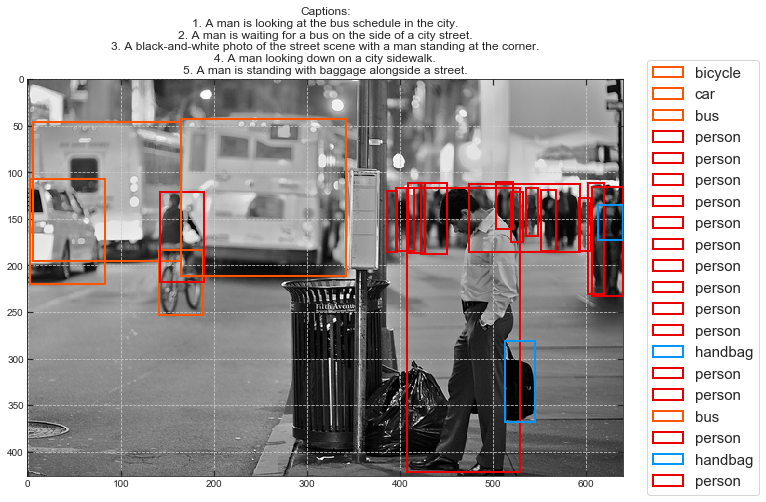

In [53]:
tr_fig_norm = 40
fig, axes = plt.subplots(figsize=tuple(t/tr_fig_norm for t in tr_example_img.shape[:2]))

axislegendsize = 15

axes.imshow(tr_example_img)

caption = 'Captions:'
for idx, entry in enumerate(tf_rand_caps):
    caption += '\n{0}. {1}'.format(idx+1, entry['caption'])
axes.set_title(caption)

for annot in tf_rand_annot:
    # Get category and supercategory
    cat_id = annot['category_id']
    super_cat = tr_labels['categories'][sub_ids[cat_id]]['supercategory']
    sub_cat = tr_labels['categories'][sub_ids[cat_id]]['name']
    color = super_cat_colors[super_cat]
    
    tr_rand_bbox = annot['bbox']
    rect = Rectangle(xy=tr_rand_bbox[:2], width=tr_rand_bbox[2], height=tr_rand_bbox[3],
                     lw=2, ec=color, fc='none', label=sub_cat)
    axes.add_patch(rect)

axes.legend(fontsize=axislegendsize,
            bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    
plt.show()